# Download Data

In [ ]:
# Download Data
# Feel free to skip this step if you already have datasets downloaded. If you are using google colab so you might have to upload the dataset. In that this step will do everything.

!wget https://home-credit-default-risk-data.s3.amazonaws.com/home-credit-default-risk.zip

!unzip home-credit-default-risk.zip

!rm home-credit-default-risk.zip

--2025-04-05 09:32:40--  https://home-credit-default-risk-data.s3.amazonaws.com/home-credit-default-risk.zip
Resolving home-credit-default-risk-data.s3.amazonaws.com (home-credit-default-risk-data.s3.amazonaws.com)... 3.5.149.15, 3.5.151.22, 3.5.148.59, ...
Connecting to home-credit-default-risk-data.s3.amazonaws.com (home-credit-default-risk-data.s3.amazonaws.com)|3.5.149.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 721616255 (688M) [application/zip]
Saving to: ‘home-credit-default-risk.zip’

home-credit-default 100%[===================>] 688.19M  16.6MB/s    in 42s     

2025-04-05 09:33:23 (16.3 MB/s) - ‘home-credit-default-risk.zip’ saved [721616255/721616255]

Archive:  home-credit-default-risk.zip
replace HomeCredit_columns_description.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Import required Packages

In [ ]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
from datetime import datetime
from tqdm.notebook import tqdm



In [ ]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# Utility Functions

### Label Encoder Vs One hot

I'm currently using get_dummies as we get the mean of many categorical features for previous applications. This Medium article (https://medium.com/data-design/visiting-categorical-features-and-encoding-in-decision-trees-53400fa65931) also shows that for a small number of categories OHE is very stable.

In [ ]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

### Helper function to reduce memory

In [ ]:
# Refer :- https://www.kaggle.com/rinnqd/reduce-memory-usage
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

def reduce_memory_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

# Read CSV files

#### Reading main application train/test csv files with reduce memory function

In [ ]:
PATH='./'

In [ ]:
app_train = reduce_memory_usage(pd.read_csv(PATH+'application_train.csv'))
print('Training data shape: ', app_train.shape)
app_train.head()

Memory usage after optimization is: 92.38 MB
Decreased by 67.7%
Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
app_test = reduce_memory_usage(pd.read_csv(PATH+'application_test.csv'))
print('Testing data shape: ', app_test.shape)
app_test.head()

Memory usage after optimization is: 14.60 MB
Decreased by 67.6%
Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


#### Reading other csv files with reduce memory function

In [ ]:
bureau = reduce_memory_usage(pd.read_csv(PATH+"bureau.csv"))
bb = reduce_memory_usage(pd.read_csv(PATH+"bureau_balance.csv"))
cc = reduce_memory_usage(pd.read_csv(PATH+"credit_card_balance.csv"))
ins = reduce_memory_usage(pd.read_csv(PATH+"installments_payments.csv"))
prev = reduce_memory_usage(pd.read_csv(PATH+"previous_application.csv"))
pos = reduce_memory_usage(pd.read_csv(PATH+"POS_CASH_balance.csv"))

Memory usage after optimization is: 112.95 MB
Decreased by 49.3%
Memory usage after optimization is: 338.46 MB
Decreased by 45.8%
Memory usage after optimization is: 289.33 MB
Decreased by 57.1%
Memory usage after optimization is: 311.40 MB
Decreased by 62.5%
Memory usage after optimization is: 309.01 MB
Decreased by 34.5%
Memory usage after optimization is: 238.45 MB
Decreased by 60.9%


In [ ]:
print("bureau -  rows:",bureau.shape[0]," columns:", bureau.shape[1])
print("bureau_balance -  rows:",bb.shape[0]," columns:", bb.shape[1])
print("credit_card_balance -  rows:",cc.shape[0]," columns:", cc.shape[1])
print("installments_payments -  rows:", ins.shape[0]," columns:", ins.shape[1])
print("previous_application -  rows:",prev.shape[0]," columns:", prev.shape[1])
print("POS_CASH_balance -  rows:",pos.shape[0]," columns:", pos.shape[1])

bureau -  rows: 1716428  columns: 17
bureau_balance -  rows: 27299925  columns: 3
credit_card_balance -  rows: 3840312  columns: 23
installments_payments -  rows: 13605401  columns: 8
previous_application -  rows: 1670214  columns: 37
POS_CASH_balance -  rows: 10001358  columns: 8


# EDA (Exploratory Data Analysis)

#### Examine the Distribution of the Target Column

In [ ]:
app_train['TARGET'].value_counts()

,count
TARGET,
0,282686
1,24825


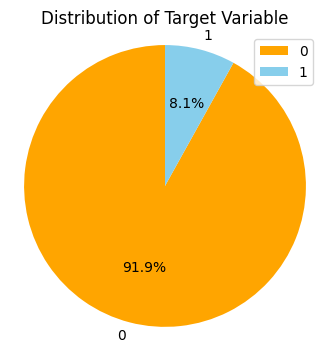

In [ ]:
target_counts = app_train['TARGET'].value_counts()

# Create a pie chart
plt.figure(figsize=(4, 4))
plt.pie(target_counts, labels=target_counts.index, autopct='%1.1f%%', startangle=90, colors=['orange', 'skyblue'])
plt.title('Distribution of Target Variable')
plt.legend(loc='upper right')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


From this information, we see this is an imbalanced class problem. There are far more loans that were repaid on time than loans that were not repaid. Once we get into more sophisticated machine learning models, we can weight the classes by their representation in the data to reflect this imbalance.

#### Examine Missing Values

In [ ]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()

        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)

        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")

        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [ ]:
# Missing values statistics
missing_values_app_test = missing_values_table(app_test)
missing_values_app_test.head(10)

Your selected dataframe has 121 columns.
There are 64 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_AVG,33495,68.7
COMMONAREA_MODE,33495,68.7
COMMONAREA_MEDI,33495,68.7
NONLIVINGAPARTMENTS_AVG,33347,68.4
NONLIVINGAPARTMENTS_MODE,33347,68.4
NONLIVINGAPARTMENTS_MEDI,33347,68.4
FONDKAPREMONT_MODE,32797,67.3
LIVINGAPARTMENTS_MODE,32780,67.2
LIVINGAPARTMENTS_AVG,32780,67.2
LIVINGAPARTMENTS_MEDI,32780,67.2


In [ ]:
missing_values_app_train = missing_values_table(app_train)
missing_values_app_train.head(10)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_MODE,214865,69.9
COMMONAREA_AVG,214865,69.9
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_AVG,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_MODE,210199,68.4


In [ ]:
missing_values_app_bureau_balance = missing_values_table(bb)
missing_values_app_bureau_balance.head(10)

Your selected dataframe has 3 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [ ]:
missing_values_app_credit_card_balance = missing_values_table(cc)
missing_values_app_credit_card_balance.head(10)

Your selected dataframe has 23 columns.
There are 9 columns that have missing values.


,Missing Values,% of Total Values
AMT_PAYMENT_CURRENT,767988,20.0
AMT_DRAWINGS_ATM_CURRENT,749816,19.5
AMT_DRAWINGS_OTHER_CURRENT,749816,19.5
AMT_DRAWINGS_POS_CURRENT,749816,19.5
CNT_DRAWINGS_ATM_CURRENT,749816,19.5
CNT_DRAWINGS_POS_CURRENT,749816,19.5
CNT_DRAWINGS_OTHER_CURRENT,749816,19.5
AMT_INST_MIN_REGULARITY,305236,7.9
CNT_INSTALMENT_MATURE_CUM,305236,7.9


In [ ]:
missing_values_app_credit_installments_payments = missing_values_table(ins)
missing_values_app_credit_installments_payments.head(10)

Your selected dataframe has 8 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
DAYS_ENTRY_PAYMENT,2905,0.0
AMT_PAYMENT,2905,0.0


In [ ]:
missing_values_app_credit_previous_application = missing_values_table(prev)
missing_values_app_credit_previous_application.head(10)

Your selected dataframe has 37 columns.
There are 16 columns that have missing values.


,Missing Values,% of Total Values
RATE_INTEREST_PRIVILEGED,1664263,99.6
RATE_INTEREST_PRIMARY,1664263,99.6
AMT_DOWN_PAYMENT,895844,53.6
RATE_DOWN_PAYMENT,895844,53.6
NAME_TYPE_SUITE,820405,49.1
DAYS_LAST_DUE,673065,40.3
DAYS_FIRST_DRAWING,673065,40.3
DAYS_FIRST_DUE,673065,40.3
DAYS_TERMINATION,673065,40.3
NFLAG_INSURED_ON_APPROVAL,673065,40.3


In [ ]:
missing_values_app_credit_POS_CASH_balance = missing_values_table(pos)
missing_values_app_credit_POS_CASH_balance.head(10)

Your selected dataframe has 8 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
CNT_INSTALMENT_FUTURE,26087,0.3
CNT_INSTALMENT,26071,0.3


#### Check data unbalance

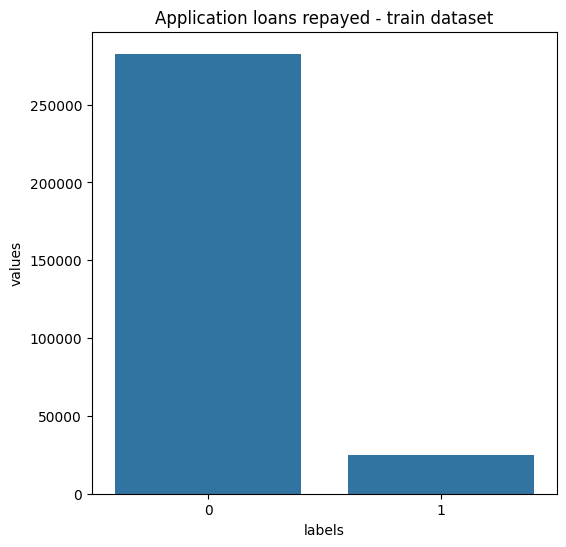

In [ ]:
temp = app_train["TARGET"].value_counts()
df = pd.DataFrame({'labels': temp.index,
                   'values': temp.values
                  })
plt.figure(figsize = (6,6))
plt.title('Application loans repayed - train dataset')
sns.set_color_codes("pastel")
sns.barplot(x = 'labels', y="values", data=df)
locs, labels = plt.xticks()
plt.show()

#### Explore the Data

#### Function to plot Univariate Bar Plot

In [ ]:
def stack_plot(data, xtick, col2='TARGET', col3='total'):
    ind = np.arange(data.shape[0])

    if len(data[xtick].unique()) < 4:
        plt.figure(figsize=(4, 4))
    elif len(data[xtick].unique()) > 4 & len(data[xtick].unique()) < 10:
        plt.figure(figsize=(6, 7))
    else:
        plt.figure(figsize=(10, 10))

    # Calculate values for default (col2) and non-default (col3 - col2)
    default_values = data[col2].values
    non_default_values = data[col3].values - default_values

    p1 = plt.bar(ind, non_default_values, label='Non-Default')
    p2 = plt.bar(ind, default_values, bottom=non_default_values, label='Default')

    plt.ylabel('Loans')
    plt.title(f'Distribution of Target Variable')
    plt.xticks(ticks=ind, rotation=45, labels=list(data[xtick].values))
    plt.legend()
    plt.show()

In [ ]:
def univariate_barplots(data, col1, col2='TARGET', top=False):
    # Group by col1 and calculate default and total counts
    temp = pd.DataFrame(data.groupby(col1)[col2].agg(
        lambda x: x.eq(1).sum())).reset_index().rename(columns={col2: 'TARGET'})  # Rename col2 to 'TARGET'

    temp['total'] = pd.DataFrame(data.groupby(col1)[col2].agg(
        total='count')).reset_index()['total']
    temp['Avg'] = pd.DataFrame(data.groupby(col1)[col2].agg(
        Avg='mean')).reset_index()['Avg']

    temp.sort_values(by=['total'], inplace=True, ascending=False)

    if top:
        temp = temp[0:top]

    stack_plot(temp, xtick=col1, col2='TARGET', col3='total')  # Pass 'TARGET' as col2
    print(temp.head(5))
    print("=" * 50)
    print(temp.tail(5))

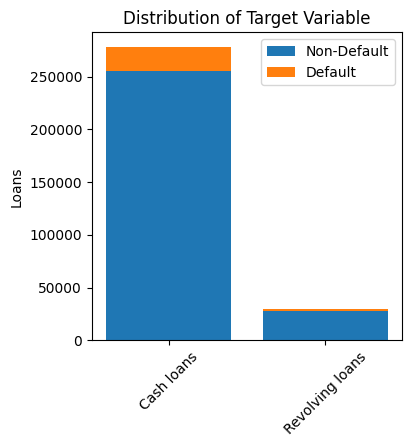

  NAME_CONTRACT_TYPE  TARGET   total       Avg
0         Cash loans   23221  278232  0.083459
1    Revolving loans    1604   29279  0.054783
  NAME_CONTRACT_TYPE  TARGET   total       Avg
0         Cash loans   23221  278232  0.083459
1    Revolving loans    1604   29279  0.054783


In [ ]:
univariate_barplots(app_train, 'NAME_CONTRACT_TYPE', 'TARGET', False)

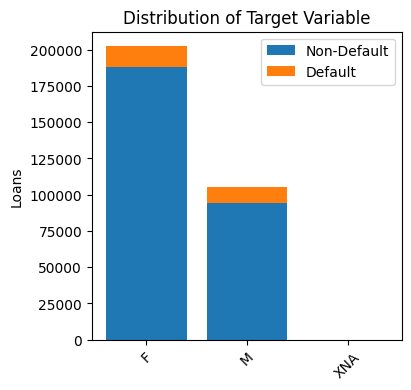

  CODE_GENDER  TARGET   total       Avg
0           F   14170  202448  0.069993
1           M   10655  105059  0.101419
2         XNA       0       4  0.000000
  CODE_GENDER  TARGET   total       Avg
0           F   14170  202448  0.069993
1           M   10655  105059  0.101419
2         XNA       0       4  0.000000


In [ ]:
univariate_barplots(app_train, 'CODE_GENDER', 'TARGET', False)

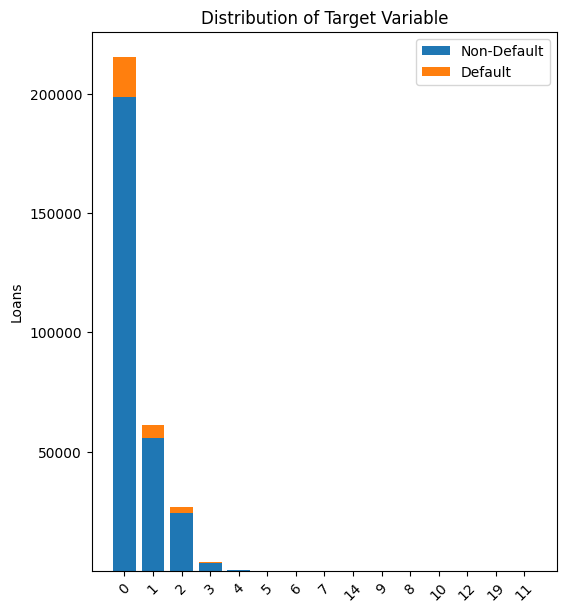

   CNT_CHILDREN  TARGET   total       Avg
0             0   16609  215371  0.077118
1             1    5454   61119  0.089236
2             2    2333   26749  0.087218
3             3     358    3717  0.096314
4             4      55     429  0.128205
    CNT_CHILDREN  TARGET  total  Avg
8              8       0      2  0.0
10            10       0      2  0.0
12            12       0      2  0.0
14            19       0      2  0.0
11            11       1      1  1.0


In [ ]:
univariate_barplots(app_train, 'CNT_CHILDREN', 'TARGET', False)

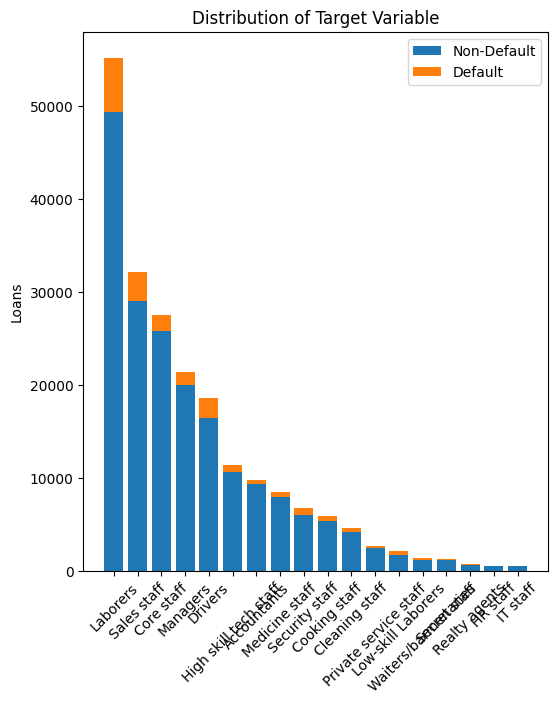

   OCCUPATION_TYPE  TARGET  total       Avg
8         Laborers    5838  55186  0.105788
14     Sales staff    3092  32102  0.096318
3       Core staff    1738  27570  0.063040
10        Managers    1328  21371  0.062140
4          Drivers    2107  18603  0.113261
         OCCUPATION_TYPE  TARGET  total       Avg
17  Waiters/barmen staff     152   1348  0.112760
15           Secretaries      92   1305  0.070498
13         Realty agents      59    751  0.078562
5               HR staff      36    563  0.063943
7               IT staff      34    526  0.064639


In [ ]:
univariate_barplots(app_train, 'OCCUPATION_TYPE', 'TARGET', False)

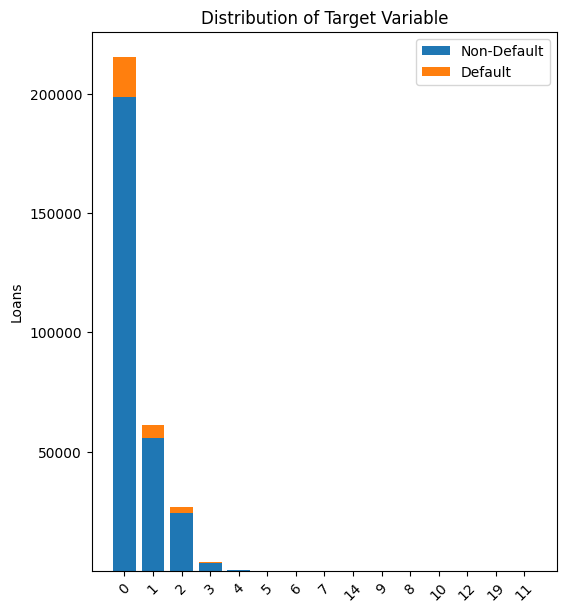

   CNT_CHILDREN  TARGET   total       Avg
0             0   16609  215371  0.077118
1             1    5454   61119  0.089236
2             2    2333   26749  0.087218
3             3     358    3717  0.096314
4             4      55     429  0.128205
    CNT_CHILDREN  TARGET  total  Avg
8              8       0      2  0.0
10            10       0      2  0.0
12            12       0      2  0.0
14            19       0      2  0.0
11            11       1      1  1.0


In [ ]:
univariate_barplots(app_train, 'CNT_CHILDREN', 'TARGET', False)

Most of the clients taking a loan have no children. The number of loans associated with the clients with one children are 4 times smaller, the number of loans associated with the clients with two children are 8 times smaller; clients with 3, 4 or more children are much more rare.

As for repayment, clients with no children, 1, 2, 3, and 5 children have percents of no repayment around the average (10%). The clients with 4 and 6 children are above average in terms of percent of not paid back loans (over 25% for families with 6 children).

As for clients with 9 or 11 children, the percent of loans not repaid is 100%.

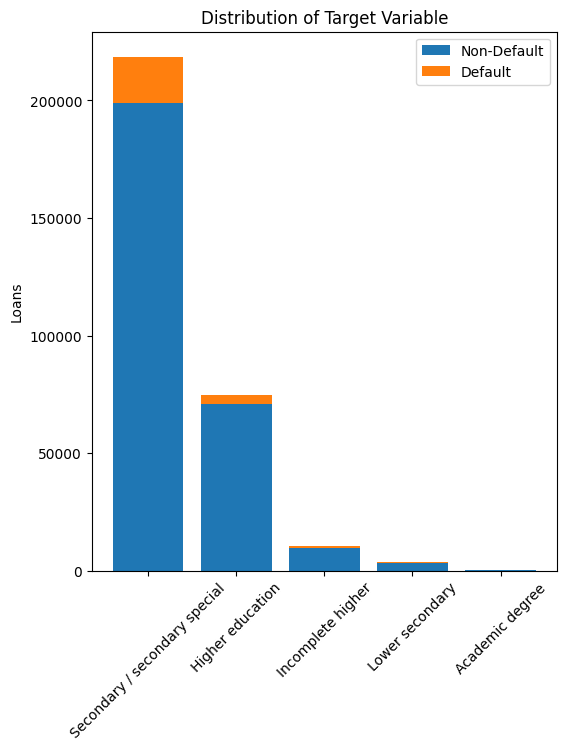

             NAME_EDUCATION_TYPE  TARGET   total       Avg
4  Secondary / secondary special   19524  218391  0.089399
1               Higher education    4009   74863  0.053551
2              Incomplete higher     872   10277  0.084850
3                Lower secondary     417    3816  0.109277
0                Academic degree       3     164  0.018293
             NAME_EDUCATION_TYPE  TARGET   total       Avg
4  Secondary / secondary special   19524  218391  0.089399
1               Higher education    4009   74863  0.053551
2              Incomplete higher     872   10277  0.084850
3                Lower secondary     417    3816  0.109277
0                Academic degree       3     164  0.018293


In [ ]:
univariate_barplots(app_train, 'NAME_EDUCATION_TYPE', 'TARGET', False)

Majority of the clients have Secondary / secondary special education, followed by clients with Higher education. Only a very small number having an academic degree.

The Lower secondary category, although rare, have the largest rate of not returning the loan (11%). The people with Academic degree have less than 2% not-repayment rate.

In [ ]:
(app_train['DAYS_BIRTH'] / -365).describe()

,DAYS_BIRTH
count,307511.000000
mean,43.936973
std,11.956133
min,20.517808
25%,34.008219
50%,43.150685
75%,53.923288
max,69.120548


In [ ]:
app_train['DAYS_EMPLOYED'].describe()

,DAYS_EMPLOYED
count,307511.000000
mean,63815.045904
std,141275.766519
min,-17912.000000
25%,-2760.000000
50%,-1213.000000
75%,-289.000000
max,365243.000000


In [ ]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


Well that is extremely interesting! It turns out that the anomalies have a lower rate of default.

In [ ]:
anom = app_test[app_test['DAYS_EMPLOYED'] == 365243]
non_anom = app_test[app_test['DAYS_EMPLOYED'] != 365243]
print('There are %d anomalous days of employment' % len(anom))
print('There are %d non_anomalous days of employment' % len(non_anom))

There are 9274 anomalous days of employment
There are 39470 non_anomalous days of employment


In [ ]:
# Find correlations with the target and sort
correlations = app_train.corr(numeric_only=True)['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DEF_60_CNT_SOCIAL_CIRCLE       0.031276
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055219
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178918
EXT_SOURCE_2                 -0.160471
EXT_SOURCE_1                 -0.155318
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044005
FLOORSMAX_MEDI               -0.043769
FLOORSMAX_MODE               -0.043228
AMT_GOODS_PRICE              -0.039645


 the DAYS_BIRTH is the most positive correlation. DAYS_BIRTH is the age in days of the client at the time of the loan in negative days (for whatever reason!).
 The correlation is positive, but the value of this feature is actually negative, meaning that as the client gets older, they are less likely to default on their loan (ie the target == 0). so we will take the absolute value of the feature and then the correlation will be negative.

In [ ]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

np.float64(-0.07823930830982694)

As clients get older, they tend to repay their loans on time more often.

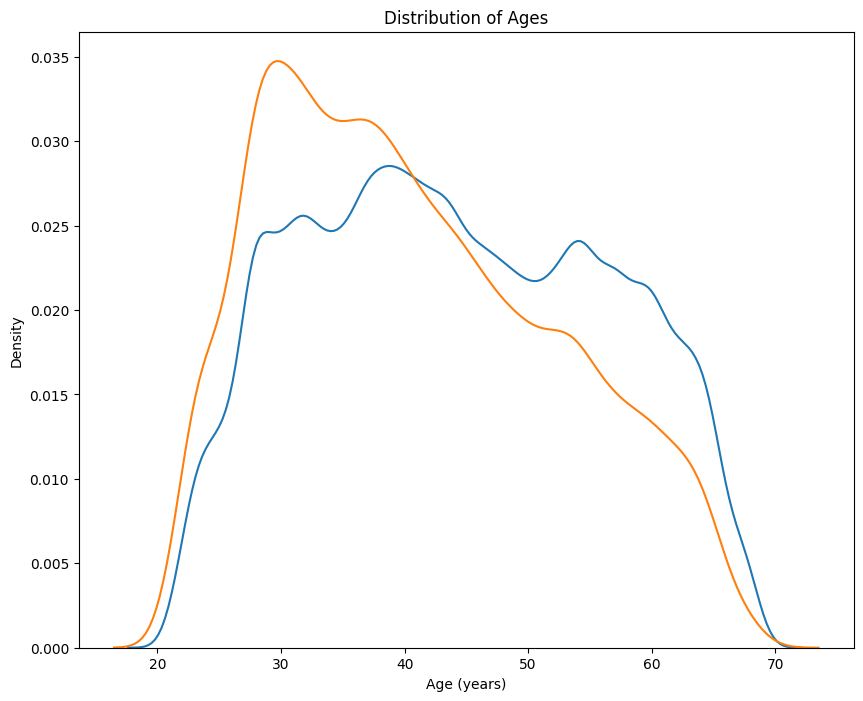

In [ ]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

In [ ]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

<ipython-input-37-487f065f0647>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365
<ipython-input-37-487f065f0647>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))


,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [ ]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


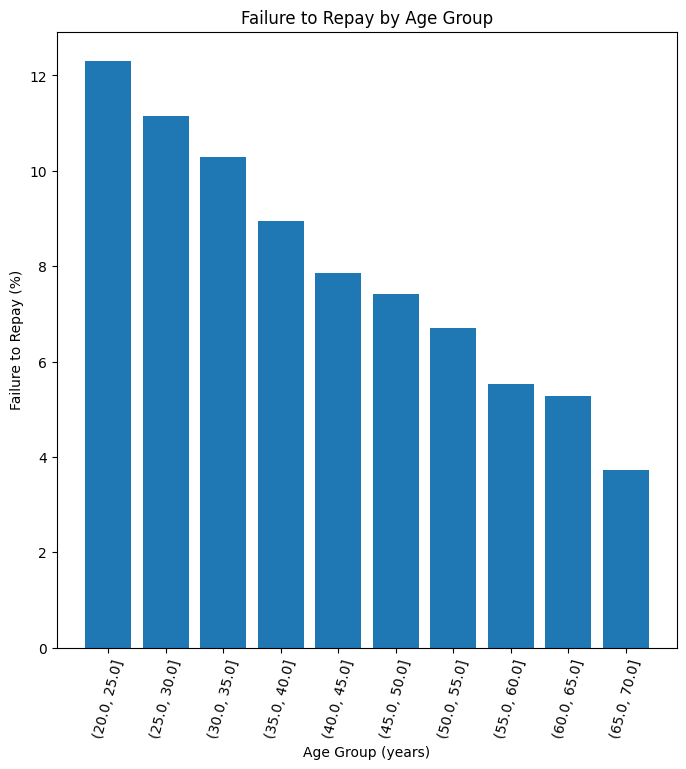

In [ ]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

There is a clear trend: younger applicants are more likely to not repay the loan! The rate of failure to repay is above 10% for the youngest three age groups and below 5% for the oldest age group.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


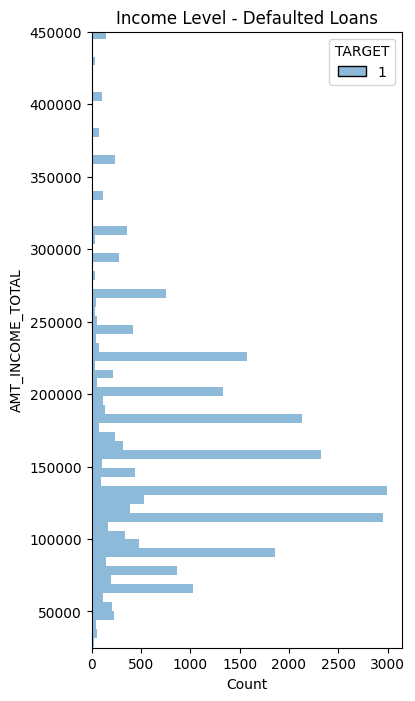

In [ ]:
fig, ax = plt.subplots(figsize=(4, 8))

sns.histplot(data = app_train[app_train.TARGET == 1],
             y = 'AMT_INCOME_TOTAL',
             hue = 'TARGET').set_title('Income Level - Defaulted Loans')

ax.set_ylim(25000, 450000)
plt.show()

In [ ]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
                      'DAYS_BIRTH', 'DAYS_EMPLOYED', 'AMT_CREDIT', 'AMT_ANNUITY']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,DAYS_EMPLOYED,AMT_CREDIT,AMT_ANNUITY
TARGET,1.000000,-0.155318,-0.160471,-0.178918,-0.078239,-0.044932,-0.030369,-0.012817
EXT_SOURCE_1,-0.155318,1.000000,0.213984,0.186842,0.600611,0.289849,0.168431,0.119400
EXT_SOURCE_2,-0.160471,0.213984,1.000000,0.109166,0.091996,-0.020768,0.131227,0.125803
EXT_SOURCE_3,-0.178918,0.186842,0.109166,1.000000,0.205477,0.113435,0.043512,0.030750
DAYS_BIRTH,-0.078239,0.600611,0.091996,0.205477,1.000000,0.615864,0.055436,-0.009445
DAYS_EMPLOYED,-0.044932,0.289849,-0.020768,0.113435,0.615864,1.000000,-0.066838,-0.104332
AMT_CREDIT,-0.030369,0.168431,0.131227,0.043512,0.055436,-0.066838,1.000000,0.770138
AMT_ANNUITY,-0.012817,0.119400,0.125803,0.030750,-0.009445,-0.104332,0.770138,1.000000


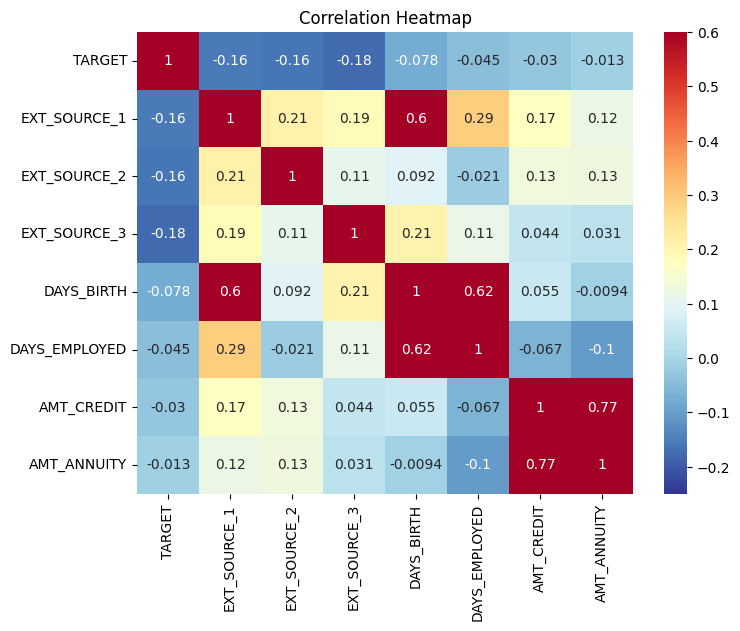

In [ ]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

All three EXT_SOURCE featureshave negative correlations with the target, indicating that as the value of the EXT_SOURCE increases, the client is more likely to repay the loan. We can also see that DAYS_BIRTH is positively correlated with EXT_SOURCE_1 indicating that maybe one of the factors in this score is the client age.

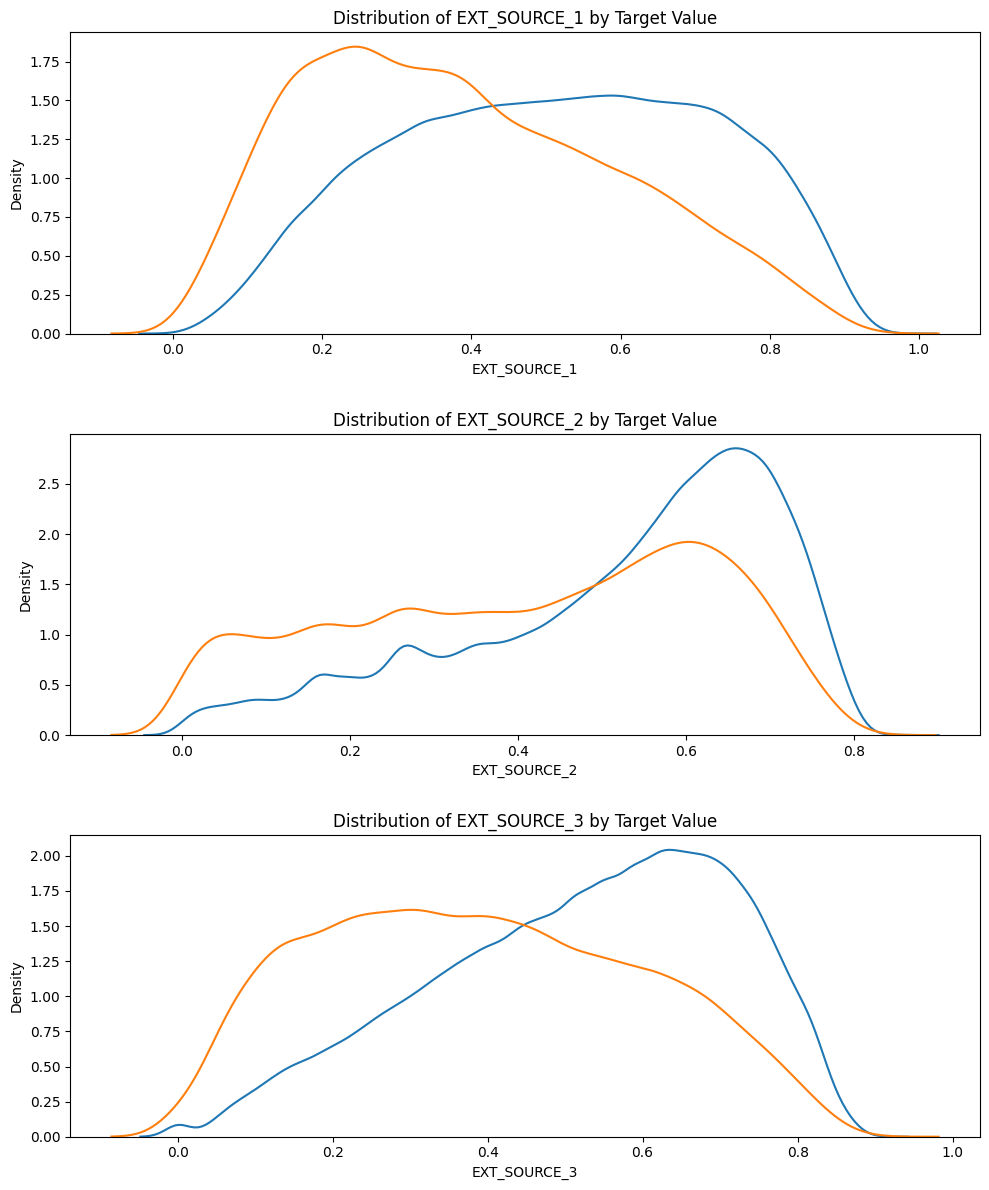

In [ ]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):

    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')

    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');

plt.tight_layout(h_pad = 2.5)

EXT_SOURCE_3 displays the greatest difference between the values of the target. We can clearly see that this feature has some relationship to the likelihood of an applicant to repay a loan. The relationship is very week.

In [ ]:
# Plot distribution of one feature
def plot_distribution(feature,color):
    plt.figure(figsize=(10,6))
    plt.title("Distribution of %s" % feature)
    sns.distplot(app_train[feature].dropna(),color=color, kde=True,bins=100)
    plt.show()

<ipython-input-44-418584406aee>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(app_train[feature].dropna(),color=color, kde=True,bins=100)


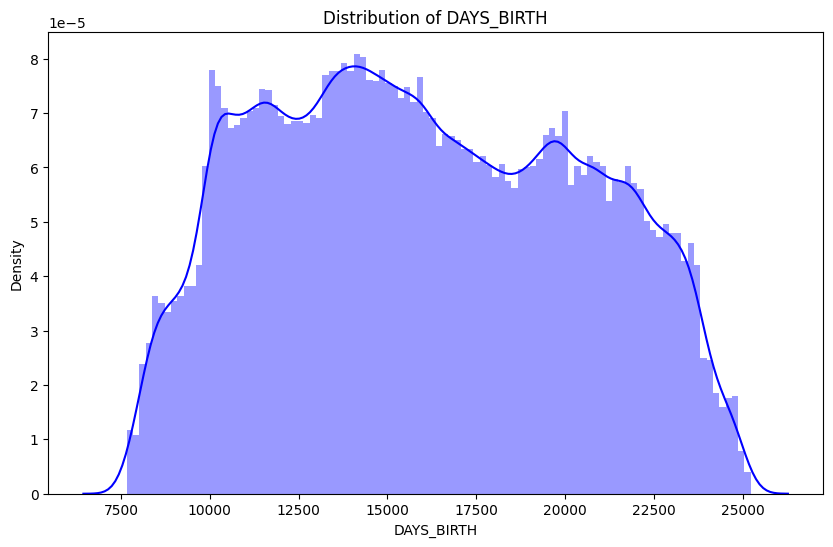

In [ ]:
plot_distribution('DAYS_BIRTH','blue')

<ipython-input-44-418584406aee>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(app_train[feature].dropna(),color=color, kde=True,bins=100)


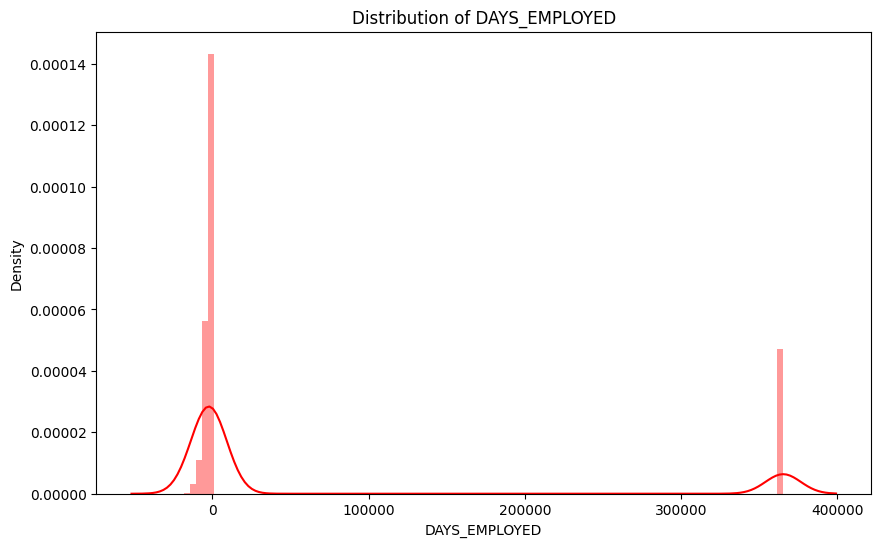

In [ ]:
plot_distribution('DAYS_EMPLOYED','red')

In [ ]:
app_bureau_train = app_train.merge(bureau, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')

In [ ]:
print("The resulting dataframe `application_bureau_train` has ",app_bureau_train.shape[0]," rows and ",
      app_bureau_train.shape[1]," columns.")

The resulting dataframe `application_bureau_train` has  1465325  rows and  138  columns.


In [ ]:
def plot_b_stats(feature,label_rotation=False,horizontal_layout=True):
    temp = app_bureau_train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = app_bureau_train[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)

    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Number of contracts",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)

    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Percent of target with value 1 [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show();

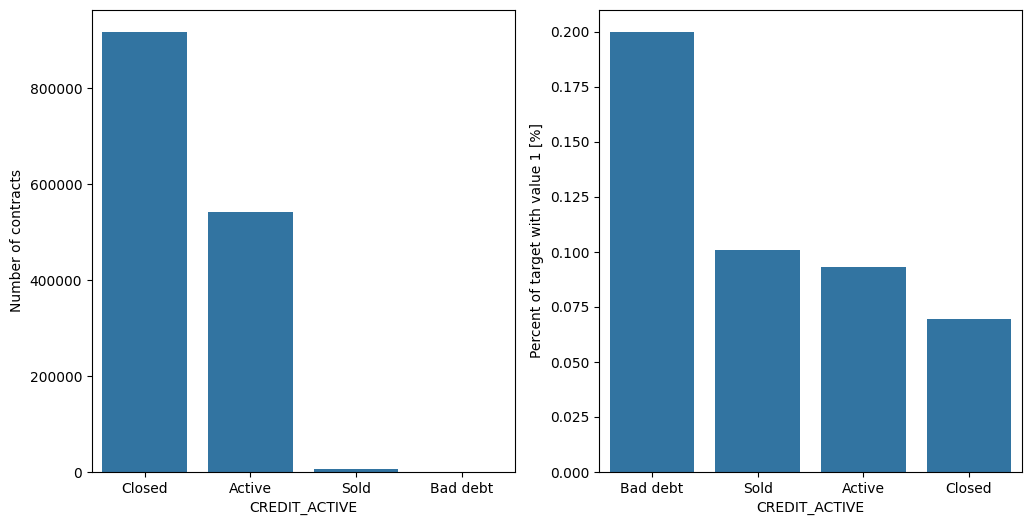

In [ ]:
plot_b_stats('CREDIT_ACTIVE')

Most of the credits registered at the Credit Bureau are in the status Closed (~900K). On the second place are the Active credits ( a bit under 600K). Sold and Bad debt are just a few.

In the same time, as percent having TARGET = 1 from total number per category, clients with credits registered to the Credit Bureau with Bad debt have 20% default on the currrent applications.

Clients with credits Sold, Active and Closed have percent of TARGET == 1 (default credit) equal or less than 10% (10% being the rate overall). The smallest rate of default credit have the clients with credits registered at the Credit Bureau with Closed credits.

That means the former registered credit history (as registered at Credit Bureau) is a strong predictor for the dafault credit, since the percent of applications defaulting with a history of Bad debt is twice as large as for Sold or Active and almost three times larger as for Closed.

<ipython-input-49-f15ac9c17f31>:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  s.set_xticklabels(s.get_xticklabels(),rotation=90)
<ipython-input-49-f15ac9c17f31>:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  s.set_xticklabels(s.get_xticklabels(),rotation=90)


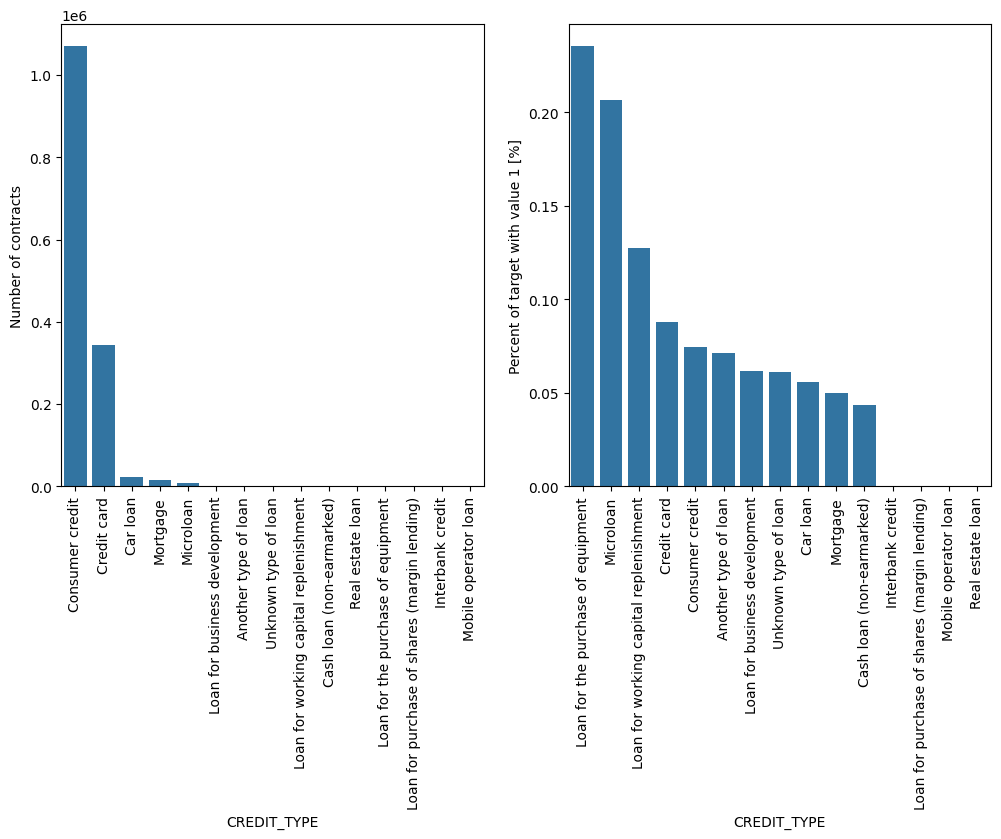

In [ ]:
plot_b_stats('CREDIT_TYPE', True, True)

Majority of historical credits registered at the Credit Bureau are Consumer credit and Credit card. Smaller number of credits are Car loan, Mortgage and Microloan.

Looking now to the types of historical credits registered at the Credit Bureau, there are few types with a high percent of current credit defaults, as following:



*   Loan for the purchase of equipment - with over 20% current credits defaults
*   Microloan - with over 20% current credits defaults
*   Loan for working capital replenishement - with over 12% current credits defaults.

<ipython-input-52-64dfd2ba4257>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(app_bureau_train[feature].dropna(),color=color, kde=True,bins=100)


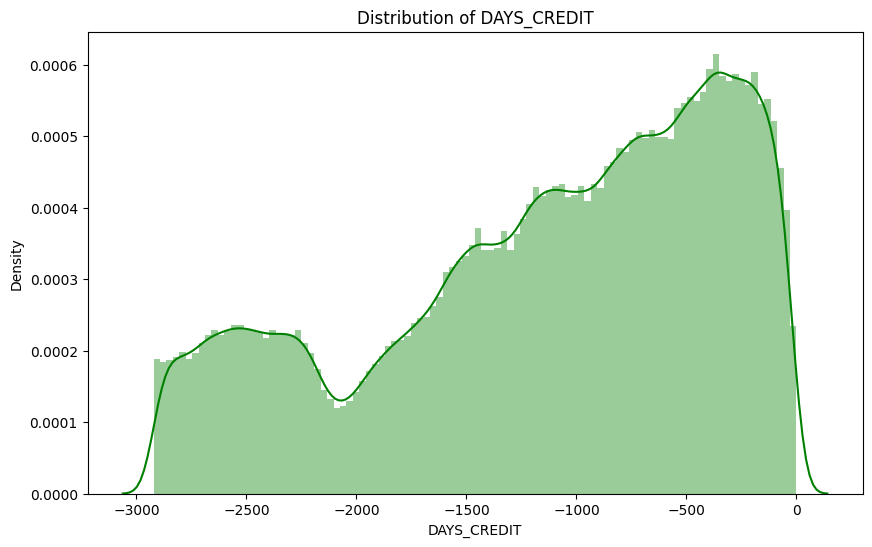

In [ ]:
def plot_b_distribution(feature,color):
    plt.figure(figsize=(10,6))
    plt.title("Distribution of %s" % feature)
    sns.distplot(app_bureau_train[feature].dropna(),color=color, kde=True,bins=100)
    plt.show()

plot_b_distribution('DAYS_CREDIT','green')

The credit duration (in days) is ranging between less than 3000 days (with a local sadle around 2000 days) and with a increasing frequence for shorter number of days - and with a peak around 300 days (or less than one year).

In [ ]:
app_prev_train = app_train.merge(prev, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='inner')

In [ ]:
print("The resulting dataframe `application_prev_train` has ",app_prev_train.shape[0]," rows and ",
      app_prev_train.shape[1]," columns.")

The resulting dataframe `application_prev_train` has  1413701  rows and  158  columns.


In [ ]:
def plot_p_stats(feature,label_rotation=False,horizontal_layout=True):
    temp = app_prev_train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = app_prev_train[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)

    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Number of contracts",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)

    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Percent of target with value 1 [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show();

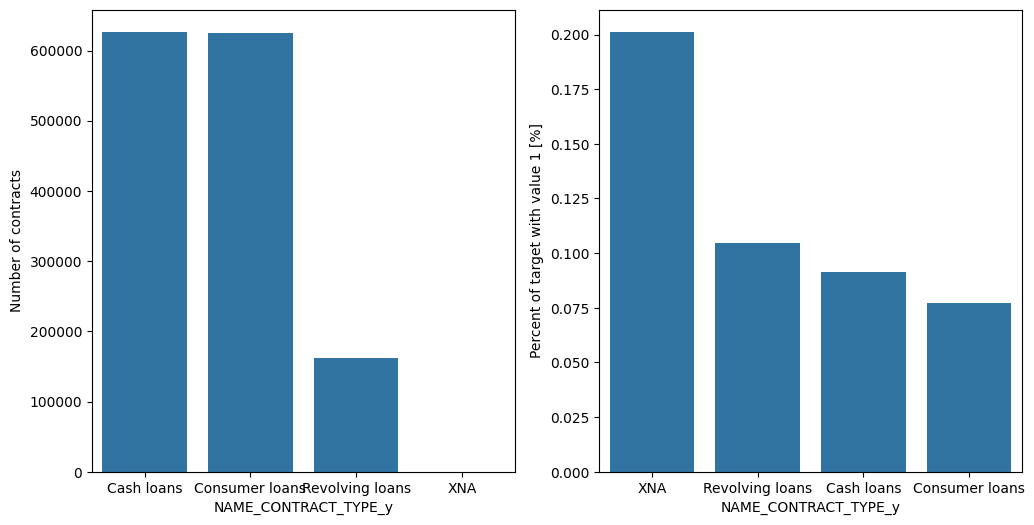

In [ ]:
plot_p_stats('NAME_CONTRACT_TYPE_y')

There are three types of contract in the previous application data: Cash loans, Consumer loans, Revolving loans. Cash loans and Consumer loans are almost the same number (600K) whilst Revolving loans are 150K.

The percent of defauls loans for clients with previous applications is different for the type of previous applications contracts, decreasing from 10% for Revolving loans, then 9.5% for Cash loans and 8% for Consumer loans.

<ipython-input-55-217c216efbb7>:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  s.set_xticklabels(s.get_xticklabels(),rotation=90)
<ipython-input-55-217c216efbb7>:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  s.set_xticklabels(s.get_xticklabels(),rotation=90)


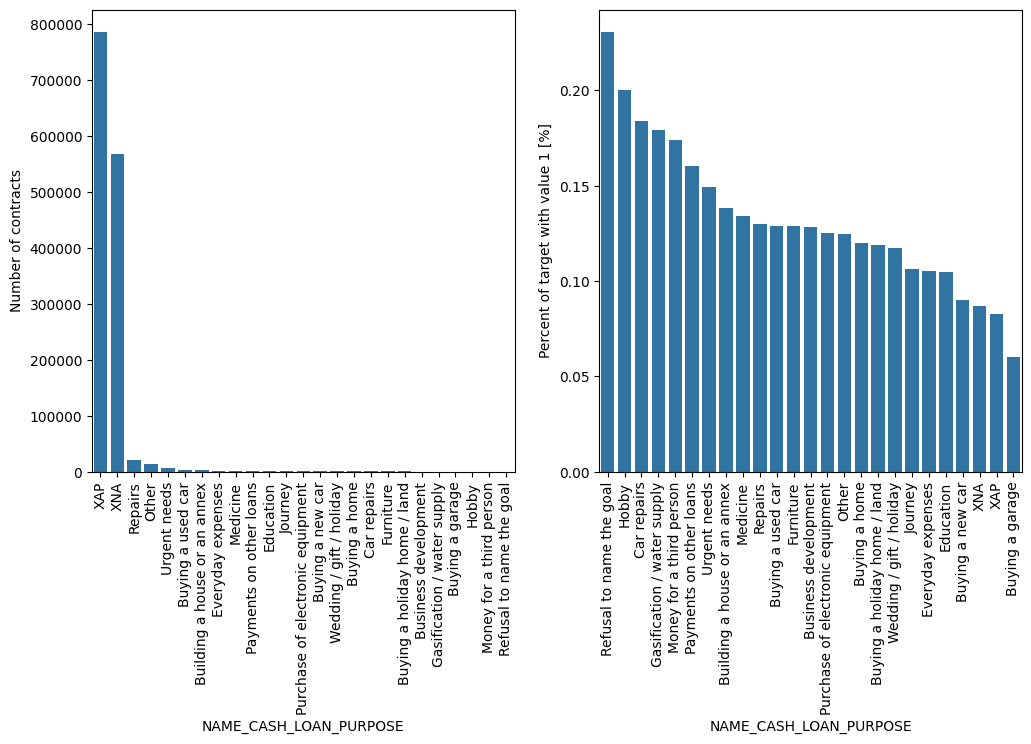

In [ ]:
plot_p_stats('NAME_CASH_LOAN_PURPOSE', True, True)

<ipython-input-55-217c216efbb7>:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  s.set_xticklabels(s.get_xticklabels(),rotation=90)
<ipython-input-55-217c216efbb7>:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  s.set_xticklabels(s.get_xticklabels(),rotation=90)


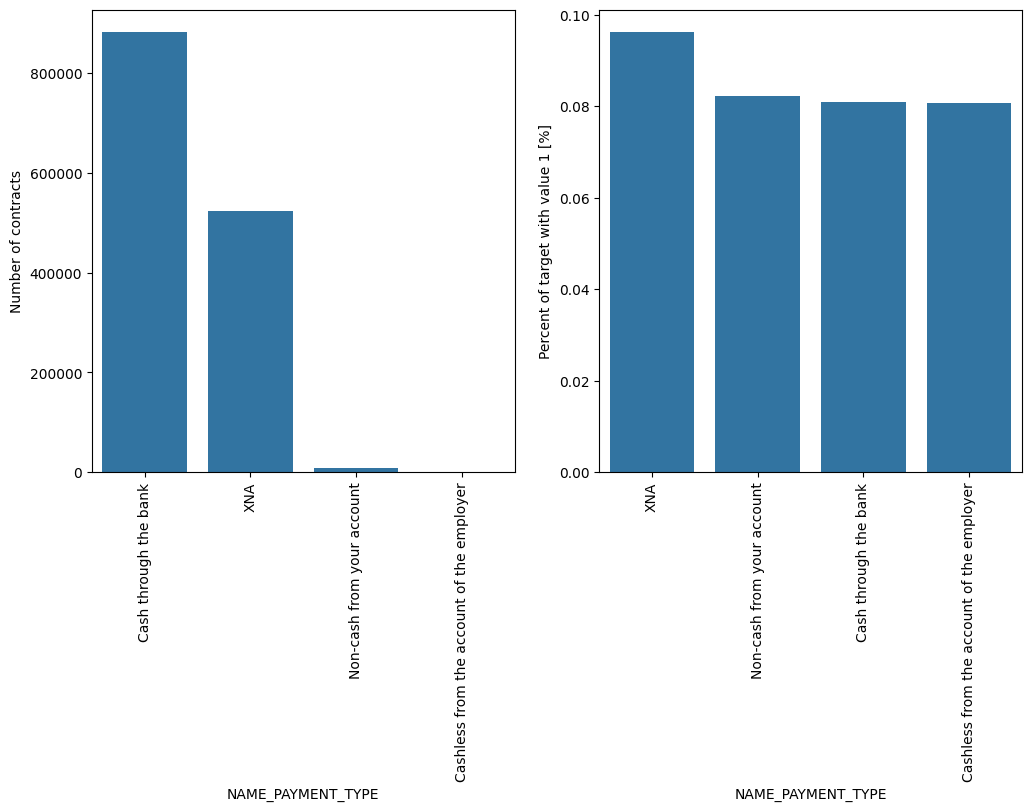

In [ ]:
plot_p_stats('NAME_PAYMENT_TYPE', True, True)

Most of the previous applications were paid with Cash through the bank (850K). Payments using Non-cash from your account or Cashless from the account of the employer are much rare. These three types of payments in previous applications results in allmost the same percent of defaults for current clients (8% each).

# Preprocessing

1. Most features are created by applying min, max, mean, sum and var functions to grouped tables.

2. Little feature selection is done and overfitting might be a problem since many features are related.

#### Application train/test

In [ ]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(app_train, app_test, nan_as_category=True):
    print("Train samples: {}, test samples: {}".format(len(app_train), len(app_test)))

    # Concatenate data
    df = pd.concat([app_train, app_test]).reset_index()

    # Categorical features: Binary features and One-Hot encoding
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)

    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    del app_test
    gc.collect()
    return df

#### Bureau and Bureau Balance Data

We have created specific features for Active credits and Closed credits.



In [ ]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(bureau, bb, nan_as_category=True):
    print("Bureau : {}, bureau balance: {}".format(len(bureau), len(bb)))

    # One-Hot encoding
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)

    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(columns='SK_ID_BUREAU', inplace=True)
    del bb, bb_agg
    gc.collect()

    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'DAYS_CREDIT_UPDATE': ['min', 'max', 'mean'],
        'AMT_ANNUITY': ['max', 'mean'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat:
        cat_aggregations[cat] = ['mean']
    for cat in bb_cat:
        cat_aggregations[cat + "_MEAN"] = ['mean']

    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])

    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACT_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()

    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLS_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()

    return bureau_agg

#### Previous Applications

created specific features for Approved and Refused applications.

In [ ]:
# Preprocess previous_applications.csv
def previous_applications(prev, nan_as_category = True):

    # One-Hot encoding
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)

    # Days 365243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APR_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REF_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

#### POS Cash Balance

In [ ]:
# Preprocess POS_CASH_balance.csv
def pos_cash(pos, nan_as_category = True):

    # One-Hot encoding
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)

    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']

    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg

#### Installment Payments

In [ ]:
# Preprocess installments_payments.csv
def installments_payments(ins, nan_as_category = True):

    # One-Hot encoding
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INS_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INS_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

#### Credit Card Balance

In [ ]:
# Preprocess credit_card_balance.csv
def credit_card_balance(cc, nan_as_category = True):

    # One-Hot encoding
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(columns = ['SK_ID_PREV'], inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

# Join all datasets on Primary Key : SK_ID_CURR

In [ ]:
def join_datasets(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(app_train, app_test)
    with timer("Process bureau and bureau_balance"):
        bureau_processed = bureau_and_balance(bureau, bb)
        print("Bureau df shape:", bureau_processed.shape)
        df = df.join(bureau_processed, how='left', on='SK_ID_CURR')
        del bureau_processed
        gc.collect()
    with timer("Process previous_applications"):
        prev_processed = previous_applications(prev)
        print("Previous applications df shape:", prev_processed.shape)
        df = df.join(prev_processed, how='left', on='SK_ID_CURR')
        del prev_processed
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos_processed = pos_cash(pos)
        print("Pos-cash balance df shape:", pos_processed.shape)
        df = df.join(pos_processed, how='left', on='SK_ID_CURR')
        del pos_processed
        gc.collect()
    with timer("Process installments payments"):
        ins_processed = installments_payments(ins)
        print("Installments payments df shape:", ins_processed.shape)
        df = df.join(ins_processed, how='left', on='SK_ID_CURR')
        del ins_processed
        gc.collect()
    with timer("Process credit card balance"):
        cc_processed = credit_card_balance(cc)
        print("Credit card balance df shape:", cc_processed.shape)
        df = df.join(cc_processed, how='left', on='SK_ID_CURR')
        del cc_processed
        gc.collect()
    return df


In [ ]:
merged_df = join_datasets()

Train samples: 307511, test samples: 48744
Bureau : 1716428, bureau balance: 27299925
Bureau df shape: (305811, 122)
Process bureau and bureau_balance - done in 21s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 31s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 12s
Installments payments df shape: (339587, 26)
Process installments payments - done in 26s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 18s


# Train/Test Split

In [ ]:
train_df = merged_df[merged_df['TARGET'].notnull()]
test_df = merged_df[merged_df['TARGET'].isnull()]
print("Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))

Train shape: (307511, 816), test shape: (48744, 816)


# Saving Train/Test for future use

In [ ]:
!mkdir -p pickles
import os

if not os.path.isfile('pickles/train_data.pkl'):
    train_df.to_pickle('pickles/train_data.pkl')
train_df = pd.read_pickle('pickles/train_data.pkl')

if not os.path.isfile('pickles/test_data.pkl'):
    test_df.to_pickle('pickles/test_data.pkl')
test_df = pd.read_pickle('pickles/test_data.pkl')

print("Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))

Train shape: (307511, 816), test shape: (48744, 816)


In [ ]:
train_df.to_csv("train_data.csv", index=False)
test_df.to_csv("test_data.csv", index=False)


In [ ]:
#from google.colab import files

#files.download("train_data.csv")


# Models

### Logistics Regression

In [ ]:
def kfold_sgd_logistic_regression(train_df, alpha=0.01, num_folds=5):
    # Clean feature names
    train_df.columns = train_df.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)

    # Drop unnecessary columns
    drop_cols = ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']
    feats = [f for f in train_df.columns if f not in drop_cols]

    # Prepare data
    X = train_df[feats].replace([np.inf, -np.inf], np.nan).fillna(0)
    y = train_df['TARGET']

    print(f"🚀 Running FULL SGD Logistic Regression Training")
    print(f"Train shape: {X.shape}")

    # Standard Scaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Stratified K-Fold setup
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

    # Set a fixed alpha
    best_alpha = alpha
    print(f"\n🔍 Using alpha = {best_alpha}")

    # Final training using the selected alpha
    print("\n🏁 Training final model using selected alpha...")
    oof_preds = np.zeros(X_scaled.shape[0])
    feature_importance_df = pd.DataFrame()
    cm_total = np.array([[0, 0], [0, 0]])

    for fold_n, (train_idx, valid_idx) in enumerate(tqdm(skf.split(X_scaled, y), total=num_folds, desc="Folds")):
        print(f"\n📂 Fold {fold_n + 1}/{num_folds}")

        X_train, X_valid = X_scaled[train_idx], X_scaled[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        clf = SGDClassifier(alpha=best_alpha, penalty='l2', loss='log_loss', random_state=42, class_weight='balanced')
        clf.fit(X_train, y_train)

        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(X_train, y_train)

        y_pred_prob = sig_clf.predict_proba(X_valid)[:, 1]  # Get predicted probabilities
        y_pred = (y_pred_prob >= 0.5).astype(int)  # Get predicted classes

        # Store out-of-fold predictions
        oof_preds[valid_idx] = y_pred_prob

        # Metrics
        fold_auc = roc_auc_score(y_valid, y_pred_prob)
        print(f"✅ Fold {fold_n+1} AUC: {fold_auc:.6f}")

        cm = confusion_matrix(y_valid, y_pred)
        cm_total += cm

        # Feature importance (absolute coefficients)
        fold_importance = pd.DataFrame({
            "feature": feats,
            "importance": np.abs(clf.coef_).flatten(),
            "fold": fold_n + 1
        })
        feature_importance_df = pd.concat([feature_importance_df, fold_importance], axis=0)

        # Confusion matrix for the fold
        plt.figure(figsize=(4, 3))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Confusion Matrix - Fold {fold_n+1}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.show()

        del X_train, X_valid, y_train, y_valid
        gc.collect()

    # Overall AUC score
    full_auc = roc_auc_score(y, oof_preds)
    print(f"\n🏁 Full AUC Score: {full_auc:.6f}")

    print("\n📉 Total Confusion Matrix (All Folds):")
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm_total, annot=True, fmt='d', cmap='Purples', cbar=False)
    plt.title('Total Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    # Compute mean feature importance across folds
    feature_importance_mean = (
        feature_importance_df.groupby("feature")["importance"]
        .mean()
        .sort_values(ascending=False)
    )

    # Select and Sort Top 30 Features
    top_features = feature_importance_mean.head(30)

    # Plot Sorted Feature Importances
    plt.figure(figsize=(12, 8))
    sns.barplot(
        x=top_features.values,
        y=top_features.index,
        palette="viridis"
    )
    plt.title('Top 30 Feature Importances (SGD Logistic Regression)')
    plt.xlabel("Importance Score")
    plt.ylabel("Feature Name")
    plt.tight_layout()
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y, oof_preds)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {full_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Out-of-Fold Predictions)')
    plt.legend(loc='lower right')
    plt.show()

    return feature_importance_df


In [ ]:
feature_importance_sgd = kfold_sgd_logistic_regression(train_df, alpha=0.01, num_folds=3)

### Random Forest

In [ ]:
def kfold_random_forest_classifier(train_df, alpha=0.01, num_folds=5):
  print(f"🚀 Running Random Forest Classifier Training")
  print(f"Train shape: {train_df.shape}")

  drop_cols = ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']
  X = train_df.drop(columns=drop_cols, errors='ignore')
  y = train_df['TARGET']


  X = X.fillna(0).replace([np.inf, -np.inf], np.nan).fillna(0)

  rf = RandomForestClassifier(
      n_estimators=100,
      max_depth=None,
      random_state=42,
      n_jobs=-1)

  skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
  oof_preds = np.zeros(X.shape[0])
  cm_total = np.array([[0, 0], [0, 0]])

  for fold, (train_idx, valid_idx) in enumerate(tqdm(skf.split(X, y), total=num_folds, desc="Folds")):
      X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
      y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

      # Train on this fold
      rf.fit(X_train, y_train)

      # Predict probabilities and classes for validation
      y_pred_prob = rf.predict_proba(X_valid)[:, 1]
      y_pred = rf.predict(X_valid)

      oof_preds[valid_idx] = y_pred_prob

      # Compute metrics
      auc = roc_auc_score(y_valid, y_pred_prob)
      print(f"✅ Fold {fold+1} AUC: {auc:.6f}")

      #acc = accuracy_score(y_valid, y_pred)
      cm  = confusion_matrix(y_valid, y_pred)

      cm_total += cm

      # Confusion matrix for the fold
      plt.figure(figsize=(4, 3))
      sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
      plt.title(f'Confusion Matrix - Fold {fold+1}')
      plt.xlabel('Predicted')
      plt.ylabel('Actual')
      plt.tight_layout()
      plt.show()


  # Overall AUC score
  full_auc = roc_auc_score(y, oof_preds)
  print(f"\n🏁 Full AUC Score: {full_auc:.6f}")

  print("\n📉 Total Confusion Matrix (All Folds):")
  plt.figure(figsize=(4, 3))
  sns.heatmap(cm_total, annot=True, fmt='d', cmap='Purples', cbar=False)
  plt.title('Total Confusion Matrix')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.tight_layout()
  plt.show()

  # Convert feature importances to a Series with columns as the index
  feature_importances = pd.Series(rf.feature_importances_, index=X.columns)

  # Sort descending and select top 30
  top30 = feature_importances.sort_values(ascending=False).head(30)

  plt.figure(figsize=(12, 8))
  sns.barplot(
      x=top30.values,  # Now correctly sorted
      y=top30.index,
      palette="viridis"
  )
  plt.title('Top 30 Feature Importances (Random Forest)')
  plt.xlabel("Importance Score")
  plt.ylabel("Feature Name")
  plt.tight_layout()
  plt.show()

  # ROC Curve
  fpr, tpr, _ = roc_curve(y, oof_preds)
  plt.figure(figsize=(6, 6))
  plt.plot(fpr, tpr, label=f'ROC curve (AUC = {full_auc:.4f})')
  plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve (Out-of-Fold Predictions)')
  plt.legend(loc='lower right')
  plt.show()

In [ ]:
kfold_random_forest_classifier(train_df, alpha=0.01, num_folds=3)


### Light GBM Model

In [ ]:
def kfold_lgbm_full(train_df, test_df, num_folds=3, stratified=True, num_boost_round=10000, early_stopping=50, save_preds=False):

    # Clean feature names
    train_df.columns = train_df.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
    test_df.columns = test_df.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
    # Clean data
    train_df = train_df.replace([np.inf, -np.inf], np.nan).fillna(0)
    test_df = test_df.replace([np.inf, -np.inf], np.nan).fillna(0)

    # Convert object columns
    def convert_object_columns(df):
        for col in df.select_dtypes(include='object').columns:
            try:
                df[col] = pd.to_numeric(df[col])
            except:
                print(f"Dropping non-numeric column: {col}")
                df.drop(columns=col, inplace=True)
        return df

    train_df = convert_object_columns(train_df)
    test_df = convert_object_columns(test_df)

    print("🚀 Running FULL LightGBM Training")
    print("Train shape: {}, Test shape: {}".format(train_df.shape, test_df.shape))

    folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1054) if stratified \
        else KFold(n_splits=num_folds, shuffle=True, random_state=1054)

    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    fold_auc_scores = []
    cm_total = np.array([[0, 0], [0, 0]])

    drop_cols = ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']
    feats = [f for f in train_df.columns if f not in drop_cols and f in test_df.columns]

    for fold_n, (train_idx, valid_idx) in enumerate(tqdm(folds.split(train_df[feats], train_df['TARGET']), total=num_folds, desc="Folds")):
        print(f"\n📂 Fold {fold_n + 1}/{num_folds}")

        X_train, y_train = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        X_valid, y_valid = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_valid = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

        params = {
            'objective': 'binary',
            'metric': 'auc',
            'learning_rate': 0.01,
            'boosting_type': 'gbdt',
            'max_depth': 4,
            'num_leaves': 31,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'lambda_l1': 0.1,
            'lambda_l2': 1.2,
            'scale_pos_weight': 2.5,
            'seed': 27,
            'verbosity': -1,
        }

        model = lgb.train(
            params,
            lgb_train,
            num_boost_round=num_boost_round,
            valid_sets=[lgb_train, lgb_valid],
            valid_names=['train', 'valid']
            #early_stopping_rounds=early_stopping,
            #verbose_eval=100
        )

        oof_preds[valid_idx] = model.predict(X_valid, num_iteration=model.best_iteration)
        sub_preds += model.predict(test_df[feats], num_iteration=model.best_iteration) / num_folds

        fold_importance = pd.DataFrame()
        fold_importance["feature"] = feats
        fold_importance["importance"] = model.feature_importance()
        fold_importance["fold"] = fold_n + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance], axis=0)

        fold_auc = roc_auc_score(y_valid, oof_preds[valid_idx])
        fold_auc_scores.append(fold_auc)
        print(f"✅ Fold {fold_n+1} AUC: {fold_auc:.6f}")

        y_pred_class = (oof_preds[valid_idx] > 0.5).astype(int)
        acc = accuracy_score(y_valid, y_pred_class)
        print(f"Validation Accuracy: {acc:.6f}")

        cm = confusion_matrix(y_valid, y_pred_class)
        cm_total += cm

        plt.figure(figsize=(4, 3))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Confusion Matrix - Fold {fold_n+1}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.show()

        del model, X_train, y_train, X_valid, y_valid, lgb_train, lgb_valid
        gc.collect()

    full_auc = roc_auc_score(train_df['TARGET'], oof_preds)
    print(f"\n🏁 Full AUC Score: {full_auc:.6f}")

    if save_preds:
        np.save("lgb_oof_preds_full.npy", oof_preds)
        np.save("lgb_sub_preds_full.npy", sub_preds)

    print("\n📊 AUC Score Summary by Fold:")
    for i, auc in enumerate(fold_auc_scores):
        print(f"  Fold {i+1}: AUC = {auc:.6f}")
    print(f"🔹 Mean AUC: {np.mean(fold_auc_scores):.6f}")
    print(f"🔹 Std Dev AUC: {np.std(fold_auc_scores):.6f}")

    print("\n📉 Total Confusion Matrix (All Folds):")
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm_total, annot=True, fmt='d', cmap='Purples', cbar=False)
    plt.title('Total Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    # Compute mean feature importance across folds
    feature_importance_mean = (
        feature_importance_df.groupby("feature")["importance"]
        .mean()
        .sort_values(ascending=False)
    )

    # Select and Sort Top 30 Features
    top_features = feature_importance_mean.head(30)

    # Plot Sorted Feature Importances
    plt.figure(figsize=(12, 8))
    sns.barplot(
        x=top_features.values,  # Now correctly sorted
        y=top_features.index,
        palette="viridis"
    )
    plt.title('Top 30 Feature Importances (LightGBM)')
    plt.xlabel("Importance Score")
    plt.ylabel("Feature Name")
    plt.tight_layout()
    plt.show()

    return sub_preds, feature_importance_df

In [ ]:
sub_preds_lgb, feat_importance_lgb = kfold_lgbm_full(train_df, test_df, num_folds=3, num_boost_round=3000, early_stopping=50)

### XGBoost Model

In [ ]:
def kfold_xgb(train_df, test_df, num_folds=3, stratified=True, num_boost_round=10000, early_stopping=100, save_preds=False):
    import gc
    from xgboost import XGBClassifier
    from sklearn.model_selection import KFold, StratifiedKFold
    from sklearn.metrics import roc_auc_score, accuracy_score
    from tqdm.notebook import tqdm
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    # Clean up infs and NaNs
    train_df = train_df.replace([np.inf, -np.inf], np.nan).fillna(0)
    test_df = test_df.replace([np.inf, -np.inf], np.nan).fillna(0)

    # Convert object columns
    def convert_object_columns(df):
        for col in df.select_dtypes(include='object').columns:
            try:
                df[col] = pd.to_numeric(df[col])
            except:
                print(f"Dropping non-numeric column: {col}")
                df.drop(columns=col, inplace=True)
        return df

    train_df = convert_object_columns(train_df)
    test_df = convert_object_columns(test_df)

    print("🚀 Running FULL XGBoost Training")
    print("Train shape: {}, Test shape: {}".format(train_df.shape, test_df.shape))

    # Define folds
    folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1054) if stratified \
        else KFold(n_splits=num_folds, shuffle=True, random_state=1054)

    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()

    drop_cols = ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']
    feats = [f for f in train_df.columns if f not in drop_cols and f in test_df.columns]
    cm_total = np.array([[0, 0], [0, 0]])

    for fold_n, (train_idx, valid_idx) in enumerate(tqdm(folds.split(train_df[feats], train_df['TARGET']),
                                                         total=num_folds, desc="Folds")):
        print(f"\n📂 Fold {fold_n + 1}/{num_folds}")

        X_train, y_train = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        X_valid, y_valid = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        model = XGBClassifier(
            learning_rate=0.05,
            n_estimators=100,
            max_depth=3,
            min_child_weight=3,
            subsample=0.8,
            colsample_bytree=0.8,
            objective='binary:logistic',
            nthread=2,
            scale_pos_weight=2.0,
            seed=27,
            reg_lambda=1.0,
            eval_metric='auc',
            use_label_encoder=False
        )

        model.fit(
            X_train, y_train,
            eval_set=[(X_valid, y_valid)],
            verbose=True
        )

        oof_preds[valid_idx] = model.predict_proba(X_valid)[:, 1]
        sub_preds += model.predict_proba(test_df[feats])[:, 1] / num_folds

        fold_importance = pd.DataFrame()
        fold_importance["feature"] = feats
        fold_importance["importance"] = model.feature_importances_
        fold_importance["fold"] = fold_n + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance], axis=0)

        fold_auc = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"✅ Fold {fold_n+1} AUC: {fold_auc:.6f}")

        y_pred = model.predict(X_valid)
        print("Validation Accuracy:", accuracy_score(y_valid, y_pred))

        cm = confusion_matrix(y_valid, y_pred)
        cm_total += cm

        plt.figure(figsize=(4, 3))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title(f'Confusion Matrix - Fold {fold_n+1}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.show()

        del model, X_train, y_train, X_valid, y_valid
        gc.collect()

    full_auc = roc_auc_score(train_df['TARGET'], oof_preds)
    print(f"\n🏁 Full AUC Score : {full_auc:.6f}")

    print("\n📉 Total Confusion Matrix (All Folds):")
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm_total, annot=True, fmt='d', cmap='Purples', cbar=False)
    plt.title('Total Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()


    # Feature Importance Plot
    # top_feats = (
    #     feature_importance_df[["feature", "importance"]]
    #     .groupby("feature").mean()
    #     .sort_values(by="importance", ascending=False)
    #     .head(30)
    #     .index
    # )
    # best_features = feature_importance_df[feature_importance_df.feature.isin(top_feats)]

    # plt.figure(figsize=(10, 10))
    # plt.title('Top 30 Feature Importances')
    # plt.barh(best_features['feature'], best_features['importance'])
    # plt.gca().invert_yaxis()
    # plt.tight_layout()
    # plt.show()

    # Compute mean feature importance across folds
    feature_importance_mean = (
        feature_importance_df.groupby("feature")["importance"]
        .mean()
        .sort_values(ascending=False)
    )

    # Select and Sort Top 30 Features
    top_features = feature_importance_mean.head(30)

    # Plot Sorted Feature Importances
    plt.figure(figsize=(12, 8))
    sns.barplot(
        x=top_features.values,  # Now correctly sorted
        y=top_features.index,
        palette="viridis"
    )
    plt.title('Top 30 Feature Importances (XGBoost)')
    plt.xlabel("Importance Score")
    plt.ylabel("Feature Name")
    plt.tight_layout()
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(train_df['TARGET'], oof_preds)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {full_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Out-of-Fold Predictions)')
    plt.legend(loc='lower right')
    plt.show()

    return sub_preds, feature_importance_df



In [ ]:
sub_preds, feat_importance = kfold_xgb(train_df, test_df, num_folds=3, num_boost_round=2000, early_stopping=100)

# Conclusion